In [35]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Patch
from shapely import wkt
from src.data.ee_utils import *
from src.data.data_utils import *
from src.data.classes import LUCAS2018_LEVEL2_CODES

LUCAS2018_LEVEL2_CODES['NOT_CROP'] = 'Not Crop'


In [36]:
data_path = '/scratch/bbug/ayang1/datasets/lucas_fused/csvs'
dfs = []

for ds in os.listdir(data_path):
    if ds.endswith('.csv') and 'Estonia' in ds:
        dfs.append(pd.read_csv(os.path.join(data_path, ds)))

df = pd.concat(dfs)
# df = df.loc[df['LABEL'] != 'NOT_CROP']

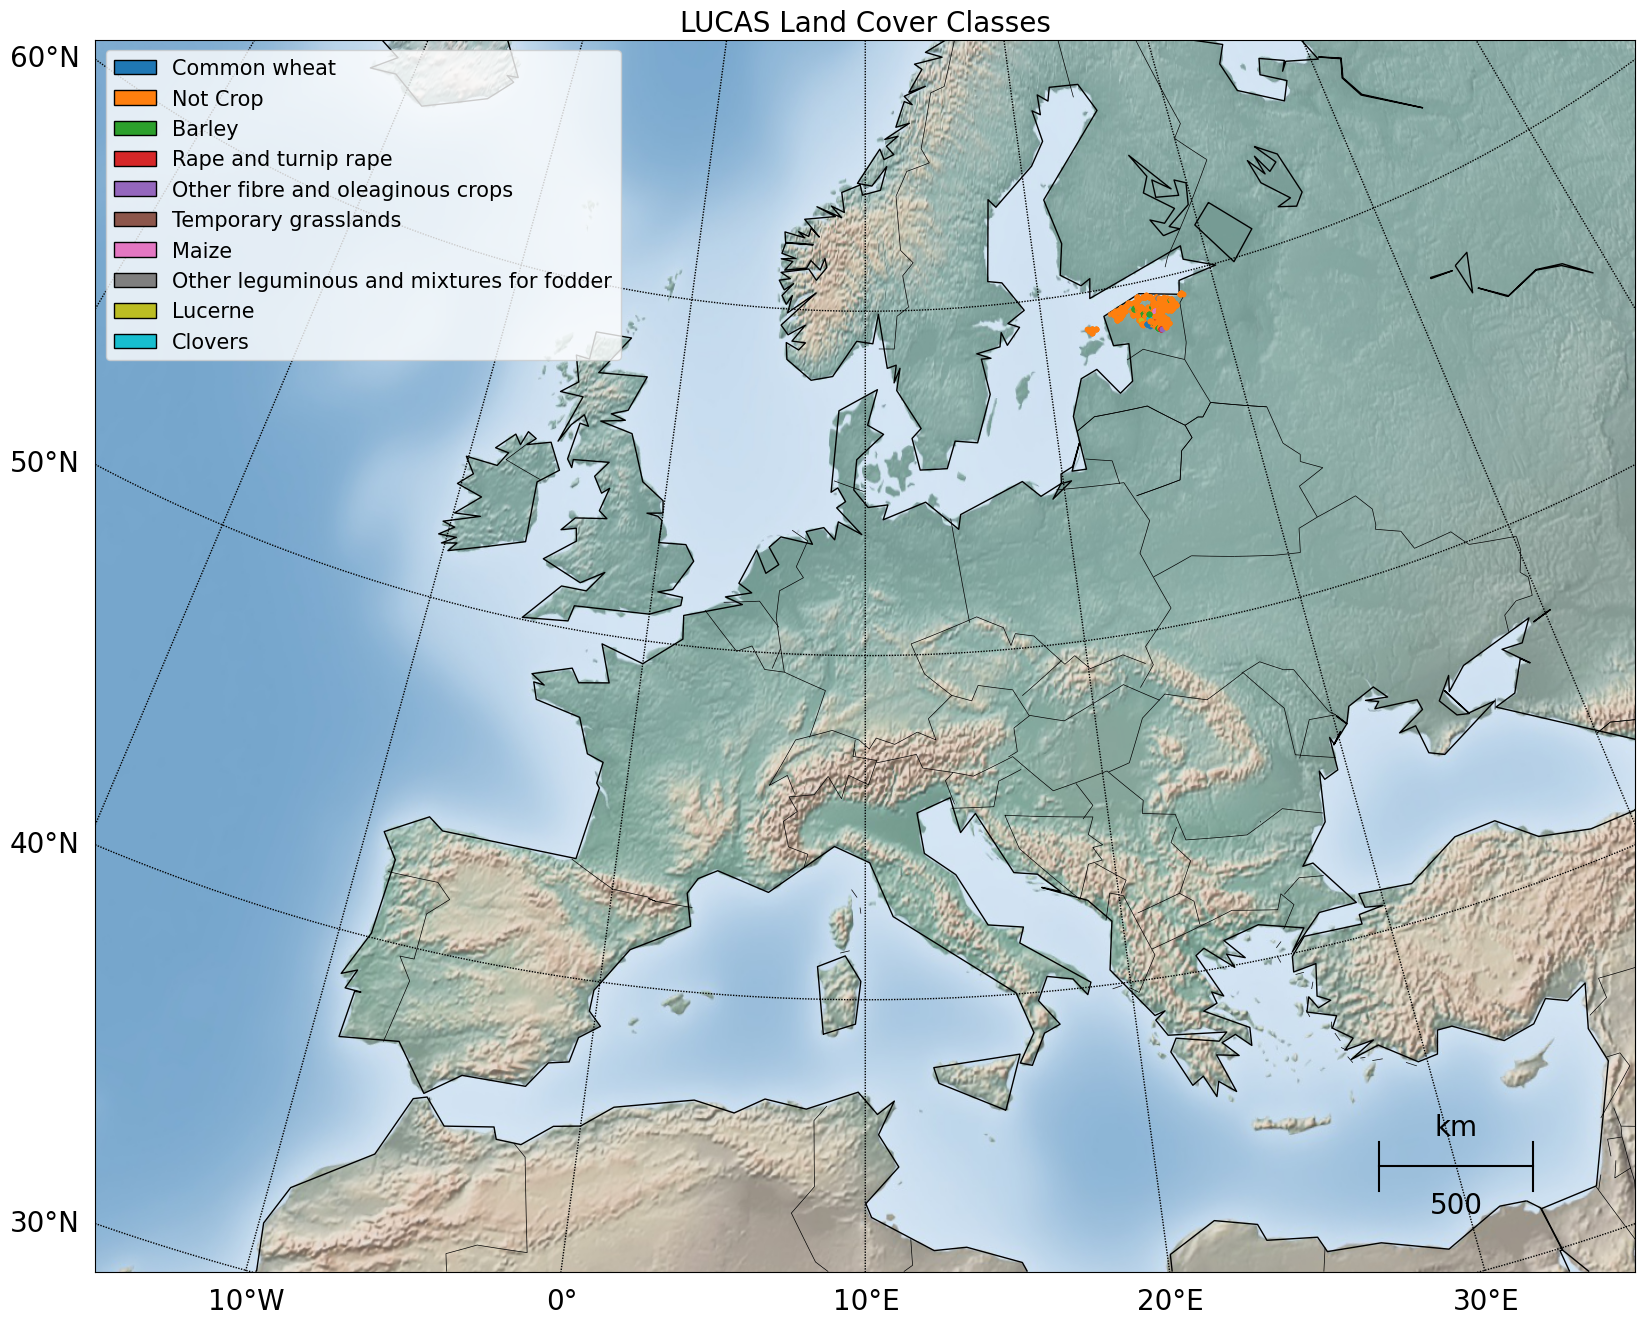

In [37]:
# Create a new figure for Basemap
plt.figure(figsize=(20, 16))
title_font=20
legend_font=15
axis_font=20

#=========Map Setup=========
# Initialize the Basemap for Europe
m = Basemap(projection='lcc', resolution='c', lat_0=50, lon_0=10, width=5E6, height=4E6)
m.drawcountries()
m.drawcoastlines()
m.shadedrelief()

# Draw latitude and longitude lines
m.drawparallels(np.arange(-80., 81., 10.), labels=[True, False, False, False], fontsize=axis_font)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[False, False, False, True], fontsize=axis_font)

# You may need to adjust these values to fit the scale bar within your map
scale_lon = 30  # Adjust this to move the scale bar left or right
scale_lat = 33  # Adjust this to move the scale bar up or down
m.drawmapscale(lon=scale_lon, lat=scale_lat, lon0=10, lat0=50, length=500, barstyle='simple', units='km', fontsize=axis_font)

#=========Plotting=========
cmap = sns.color_palette('tab10', len(df['LABEL'].unique()))
colors = {label: cmap[i] for i, label in enumerate(df['LABEL'].unique())}

for index, row in df.iterrows():
    geom = ast.literal_eval(row['geo'])
    x, y = m(geom['coordinates'][0], geom['coordinates'][1])
    plt.plot(x, y, marker='o',color=colors[row['LABEL']], markersize=3, alpha=0.8)

legend_elements = [Patch(facecolor=colors[crop], edgecolor='black',
                     label=LUCAS2018_LEVEL2_CODES[crop]) for crop in colors.keys()]
plt.legend(handles=legend_elements, loc='upper left', fontsize=legend_font)
plt.title('LUCAS Land Cover Classes', fontsize=title_font)
plt.show()
# plt.savefig('./LUCAS_plot.png')

In [4]:
#=========Time Series Plots=========
band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'VH', 'VV']
band_data = {}
labels = df['LABEL'].to_numpy()


for band in band_names:
    band_df = df.loc[:, df.columns.str.contains(band)]]
    col_names = list(band_df.columns)
    col_names.sort(key=lambda x: int(x.split('_')[0]) if band in x else 0)
    band_df = band_df.reindex(col_names, axis=1)
    band_data[band] = band_df

In [8]:
import pandas as pd
import numpy as np
import ee
import os
import geemap

from src.data.ee_utils import *
from src.data.data_utils import *
from src.data.dataset import *

ee.Initialize()
ee.Authenticate()

GAUL0 = ee.FeatureCollection("FAO/GAUL/2015/level0")
GAUL1 = ee.FeatureCollection("FAO/GAUL/2015/level1")

In [54]:
def split_region(provinces, n):
    subset_geoms = []
    size = provinces.size().getInfo()
    step = size // n
    
    for i in range(n):
        start = i * step
        end = (i + 1) * step if i < n - 1 else size
        subset_geom = ee.FeatureCollection(provinces.slice(start, end))
        subset_geoms.append(subset_geom)
    
    return subset_geoms

country = 'Poland'
provinces = GAUL1.filter(ee.Filter.eq("ADM0_NAME", country))
provinces = provinces.toList(provinces.size().getInfo())
provinces = split_region(provinces, 10)

In [55]:
start_date = "2018-01-01"
end_date = "2019-01-01"
step = 10  # Days to step for averages
export_scale = 30
save_path = "/scratch/bbug/ayang1/datasets/lucas_fused/csvs"

In [56]:
idx = 9
roi = provinces[idx]
sub_rois = split_region(roi.toList(roi.size().getInfo()), 5)
dfs = []
names = []
for i, sub_roi in enumerate(sub_rois):
    try: 
        _, _, _, fused_df = generate_fused(
            sub_roi.geometry(),
            start_date,
            end_date,
            step,
            export_scale=export_scale,
            geometries=True,
        )
        filename = f"fused_{country}_subset_{idx}_{i}.csv"
        fused_df["country"] = country
        dfs.append(fused_df)
        names.append(filename)
        
    except Exception as e:
        print(f"Failed to generate fused data for {country} subset {idx} part {i}")
        print(e)
        continue
    
# fused_df.to_csv()
# print(f"created dataset for {country} with length {len(fused_df)}")

Loading files
Creating dataset of size 1779


100%|██████████| 1779/1779 [00:00<00:00, 2583.28it/s]


Loading files
Creating dataset of size 1606


100%|██████████| 1606/1606 [00:00<00:00, 2143.81it/s]


Loading files
Creating dataset of size 1238


100%|██████████| 1238/1238 [00:00<00:00, 2219.37it/s]


Loading files
Creating dataset of size 1061


100%|██████████| 1061/1061 [00:00<00:00, 2163.35it/s]


Loading files
Creating dataset of size 6519


100%|██████████| 6519/6519 [00:01<00:00, 3540.88it/s]
